#Analyzing Residential FAR Utilization in Atlanta
---
This notebook documents the methodology used to analyze the ratio of real built square footage on each parcel versus the total allowed square footage allowed per parcel according to each parcel's lot size and zoning requirements. 

**Objective:**

To better understand whether zoning requirements are restricting the level of density per land area or if the market actually doesn't demand higher building density and more vertical development.

**Limits of analysis and assumptions:**
- Only analyzed residential parcels in the City of Atlanta
- ~18% of the parcels had a null value recorded for building square footage (BldgSF). This research excluded the null entries and did not analyze analyze vacant land and parcels with BldgSF recorded < 400 square feet
- ~22% of the parcels had a lot size in square feet (LotSize) recorded as zero. This research did not analyze parcels with a LotSize recorded < 400 square feet
- Excluded all parcels within SPI zones and all parcels with -C zoning


##0. Importing packages

In [2]:
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as pl
import numpy as np
%pylab inline
import statsmodels.api as sm1
import statsmodels.formula.api as sm
from shapely.geometry import Point, MultiPolygon

Populating the interactive namespace from numpy and matplotlib


------
##1. Importing data

####SCI Tax Data
- Description: http://www.atlantaga.gov/index.aspx?page=1070
- Direct download: http://ditweb.atlantaga.gov/sci/sci1.xlsx

In [3]:
sci2013 = pd.read_csv('/Users/hannahbkates/Desktop/Markets/Project/sci1.csv')
print sci2013.columns

Index([u'PARID', u'NPU', u'Neighborhood_Name', u'SCI_Landuse', u'Photographs',
       u'Lot_Condition', u'Structure_Condition', u'Sidewalks',
       u'Multiple_Violations', u'TMA', u'Market', u'County', u'SiteAddres',
       u'SiteCity', u'State', u'SiteZip', u'Subdivisio', u'LegalDesc',
       u'Legal1', u'Legal2', u'Legal3', u'Legal4', u'Lot', u'Block',
       u'Section_', u'Township', u'Range', u'MapGrid', u'MapPage', u'Bedrooms',
       u'Bathrooms', u'Stories', u'Units', u'Garages', u'LandUseGen',
       u'LandUseSpe', u'LotSize', u'BldgSF', u'YrBuilt', u'Owner_1',
       u'OwnerAdd', u'OwnerUnit', u'OwnerCity', u'OwnerZip', u'OwnerOcc',
       u'OwnerType', u'TaxYear_1', u'TaxVal', u'TranType', u'DocType',
       u'DistressFl', u'DistressDe', u'Seller', u'SellerType', u'Purchaser',
       u'PurchaserT', u'TranQtr', u'TranDate', u'ContractDa', u'FeedDate',
       u'TranVal', u'AVM', u'LoanValTot', u'Lender1', u'LoanVal1',
       u'LoanType1', u'IntRateTyp', u'Lender2', u'LoanVal2'

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2871: DtypeWarning: Columns (15,29,30,31,32,37,43,45,59) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
print len(sci2013)
print len(sci2013[sci2013.LotSize == 0]), 100*len(sci2013[sci2013.LotSize == 0])/len(sci2013)
print len(sci2013[sci2013.BldgSF.isnull()]), 100*len(sci2013[sci2013.BldgSF.isnull()])/len(sci2013)

160207
36751 22
29946 18


#####Clean up in order to run calculations

In [5]:
sci = sci2013[(sci2013.BldgSF.notnull()) & (sci2013.LotSize >= 400)]

sci.BldgSF = [float(entry) for entry in sci.BldgSF]

sci = sci[sci.BldgSF >= 400]

sci['built_far'] = sci.BldgSF/sci.LotSize

sci.YrBuilt = sci.YrBuilt.replace(' ', 0, regex=True)
sci.YrBuilt = [int(yr) for yr in sci.YrBuilt]
sci.YrBuilt = [float(yr) for yr in sci.YrBuilt]

print len(sci)
print sci.columns.values

112250
['PARID' 'NPU' 'Neighborhood_Name' 'SCI_Landuse' 'Photographs'
 'Lot_Condition' 'Structure_Condition' 'Sidewalks' 'Multiple_Violations'
 'TMA' 'Market' 'County' 'SiteAddres' 'SiteCity' 'State' 'SiteZip'
 'Subdivisio' 'LegalDesc' 'Legal1' 'Legal2' 'Legal3' 'Legal4' 'Lot' 'Block'
 'Section_' 'Township' 'Range' 'MapGrid' 'MapPage' 'Bedrooms' 'Bathrooms'
 'Stories' 'Units' 'Garages' 'LandUseGen' 'LandUseSpe' 'LotSize' 'BldgSF'
 'YrBuilt' 'Owner_1' 'OwnerAdd' 'OwnerUnit' 'OwnerCity' 'OwnerZip'
 'OwnerOcc' 'OwnerType' 'TaxYear_1' 'TaxVal' 'TranType' 'DocType'
 'DistressFl' 'DistressDe' 'Seller' 'SellerType' 'Purchaser' 'PurchaserT'
 'TranQtr' 'TranDate' 'ContractDa' 'FeedDate' 'TranVal' 'AVM' 'LoanValTot'
 'Lender1' 'LoanVal1' 'LoanType1' 'IntRateTyp' 'Lender2' 'LoanVal2'
 'LoanType2' 'IntRateT_1' 'TitleCo' 'built_far']


//anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2273: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


####Pre-joined (in QGIS) Zoning Base and Tax Parcel Shp Data
- Description: http://gis.atlantaga.gov/apps/gislayers/, 
- Parcels direct download: http://gis.atlantaga.gov/apps/gislayers/download/layers/COA_Parcels_2014.zip
- Zoning direct download: http://gis.atlantaga.gov/apps/gislayers/download/layers/ZoningBaseUpdated082014.zip
- Spatial join was performed using the centroids of the parcels

In [6]:
parcels_shp = gp.GeoDataFrame.from_file('/Users/hannahbkates/Desktop/Markets/Project/atl_shp/parcels_zoning.shp')
print parcels_shp.columns

Index([     u'ACRES',   u'ADDRESS1',   u'ADDRESS2',   u'ADDRESS3',
         u'ADDRESS5', u'ADDRPOSDIR', u'ADDRPREDIR', u'ADDRSTREET',
       u'ADDRSUFFIX', u'ADDRUNTTYP',    u'ADDUNIT',     u'ATLPIN',
           u'ATRPIN',     u'CASEIN',    u'CASEOUT',      u'CLASS',
           u'COUNTY', u'CREATEDATE',  u'CREATEDBY',     u'DIGEST',
           u'EXTVER', u'FUL_EX_COD', u'GIS_LAND_P',         u'ID',
       u'IMPRASSESS',  u'IMPR_APPR', u'LANDASSESS', u'LANDUSEGEN',
       u'LANDUSESPE', u'LANDUSE_DE',  u'LAND_APPR',  u'LIV_UNITS',
       u'LOT_CONDIT',        u'LUC',     u'MARKET', u'MULTIPLE_V',
             u'NBHD', u'NEIGHBORHO',        u'NPU',     u'OLD_ID',
            u'OWNER',    u'OWPART2',      u'PARID',      u'PCODE',
       u'PHOTOGRAPH',        u'PIN', u'PROP_CLASS', u'SCI_LANDUS',
       u'SHAPE_AREA', u'SHAPE_AR_2',  u'SHAPE_LEN', u'SHAPE_LE_2',
         u'SIDEWALK',   u'SITECITY',    u'SITEZIP',      u'SITUS',
              u'SPI',      u'STATE',     u'STATUS', u'STATUS_C

#### Creating list of all distinct ZONING designations assigned to the parcels

In [32]:
all_zones = sorted(set(parcels_shp.ZONING))
# print all_zones
all_zones = pd.DataFrame(all_zones)
# all_zones.to_csv('/Users/hannahbkates/Desktop/Markets/Project/allzones.csv')

In [8]:
print pd.DataFrame(parcels_shp.ZONING.groupby(parcels_shp.ZONING).count()).tail(50)

                  0
ZONING             
SPI-17 SA2      507
SPI-17 SA3       18
SPI-17 SA4      386
SPI-18 SA1      188
SPI-18 SA10      92
SPI-18 SA2       40
SPI-18 SA3       87
SPI-18 SA4      312
SPI-18 SA5      362
SPI-18 SA6      185
SPI-18 SA7       17
SPI-18 SA8       11
SPI-18 SA9       28
SPI-19 overlay   87
SPI-20 SA1       18
SPI-20 SA2       46
SPI-20 SA3       27
SPI-20 SA4       17
SPI-20 SA5       15
SPI-20 SA6       21
SPI-21 SA1        5
SPI-21 SA10       1
SPI-21 SA2       35
SPI-21 SA3       48
SPI-21 SA4       47
SPI-21 SA5      235
SPI-21 SA6       13
SPI-21 SA7        1
SPI-21 SA8       27
SPI-21 SA9       41
SPI-22 SA1        7
SPI-22 SA2       19
SPI-22 SA3       19
SPI-22 SA4      201
SPI-22 TSA       67
SPI-5 SA1        41
SPI-5 SA2         2
SPI-5 SA3        28
SPI-6 SA2         1
SPI-6 SA3         1
SPI-6 SA4         4
SPI-7 SA1         2
SPI-7 SA2A       18
SPI-7 SA2B        7
SPI-7 SA2C       48
SPI-7 SA3        17
SPI-9 SA1       683
SPI-9 SA2        95


####Zoning Table Summary
- Contains restictions for residential zoning types
- Full zoning ordinance manual: https://www.municode.com/library/ga/atlanta/codes/code_of_ordinances?nodeId=PTIIICOORANDECO_PT16ZO

In [9]:
zoning = pd.read_csv('/Users/hannahbkates/Desktop/Markets/Project/zoning_summary.csv')
print zoning

         zone   front  side  rear    lot  frontage  height  footprint  \
0         R-1      60    25    35  87120       200      35       0.25   
1         R-2      60    15    30  43560       150      35       0.35   
2        R-2A      60    15    30  30000       100      35       0.35   
3        R-2B      50    10    20  28000       100      35       0.40   
4         R-3      50    10    20  18000       100      35       0.40   
5        R-3A      50    10    15  13500        85      35       0.45   
6         R-4      35     7    15   9000        70      35       0.50   
7        R-4A      30     7    15   7500        50      35       0.55   
8        R-4B      20     5     5   2800        40      35       0.85   
9         R-5      30     7     7   7500        50      35       0.55   
10       RG-1      40   NaN   NaN   5000       NaN     NaN        NaN   
11       RG-2      40   NaN   NaN   5000       NaN     NaN        NaN   
12       RG-3      40   NaN   NaN   5000       NaN 

----
##2. Joining datasets and zoning criteria

####PARCELS: Joining SCI data with Tax Parcel shp file data on parcel ID (PARID)

####Testing match rate on PARID between datasets

In [10]:
sciPARIDs = pd.DataFrame(sorted(set(sci2013.PARID.values)))
print len(sciPARIDs), 'distinct PARIDs in the SCI dataset'
sciPARIDs.rename(columns={0:'PARID'}, inplace=True)
sciPARIDs['sci_PARID'] = sciPARIDs.PARID
# sciPARIDs.to_csv('/Users/hannahbkates/Desktop/Markets/Project/sciPARIDs.csv')

shpPARIDs = pd.DataFrame(sorted(set(parcels_shp.PARID.values)))
print len(shpPARIDs), 'distinct PARIDs in the shapefile dataset'
shpPARIDs.rename(columns={0:'PARID'}, inplace=True)
shpPARIDs['shp_PARID'] = shpPARIDs.PARID
# shpPARIDs.to_csv('/Users/hannahbkates/Desktop/Markets/Project/shpPARIDs.csv')

matching1 = pd.merge(shpPARIDs, sciPARIDs, how='outer', left_on='PARID', right_on='PARID')
matching2 = matching1[matching1.shp_PARID != matching1.sci_PARID]
print len(matching1), 'distinct PARIDs in the combined datasets'
print len(matching2), 'distinct PARIDs lack spatial/zoning data or tax appraisal data (only present in one dataset)'
print 100*float(len(matching2))/float(len(matching1)), '% of parcels lack spatial/zoning data or tax appraisal data (only present in one dataset)'
# matching2.to_csv('/Users/hannahbkates/Desktop/Markets/Project/unmatched.csv')

160098 distinct PARIDs in the SCI dataset
164559 distinct PARIDs in the shapefile dataset
165729 distinct PARIDs in the combined datasets
6801 distinct PARIDs lack spatial/zoning data or tax appraisal data (only present in one dataset)
4.103687345 % of parcels lack spatial/zoning data or tax appraisal data (only present in one dataset)


####4.1% of all distinct parcels did not have a match in both datasets

In [18]:
parcels = pd.merge(parcels_shp, sci, how = 'inner', left_on = 'PARID', right_on = 'PARID')

In [20]:
print parcels.columns.values
print len(parcels)

[u'ACRES' u'ADDRESS1' u'ADDRESS2' u'ADDRESS3' u'ADDRESS5' u'ADDRPOSDIR'
 u'ADDRPREDIR' u'ADDRSTREET' u'ADDRSUFFIX' u'ADDRUNTTYP' u'ADDUNIT'
 u'ATLPIN' u'ATRPIN' u'CASEIN' u'CASEOUT' u'CLASS' u'COUNTY' u'CREATEDATE'
 u'CREATEDBY' u'DIGEST' u'EXTVER' u'FUL_EX_COD' u'GIS_LAND_P' u'ID'
 u'IMPRASSESS' u'IMPR_APPR' u'LANDASSESS' u'LANDUSEGEN' u'LANDUSESPE'
 u'LANDUSE_DE' u'LAND_APPR' u'LIV_UNITS' u'LOT_CONDIT' u'LUC' u'MARKET'
 u'MULTIPLE_V' u'NBHD' u'NEIGHBORHO' u'NPU_x' u'OLD_ID' u'OWNER' u'OWPART2'
 u'PARID' u'PCODE' u'PHOTOGRAPH' u'PIN' u'PROP_CLASS' u'SCI_LANDUS'
 u'SHAPE_AREA' u'SHAPE_AR_2' u'SHAPE_LEN' u'SHAPE_LE_2' u'SIDEWALK'
 u'SITECITY' u'SITEZIP' u'SITUS' u'SPI' u'STATE' u'STATUS' u'STATUS_COD'
 u'STRUCTURE_' u'STRUCT_FLR' u'STRUCT_YR' u'STR_NUMBER' u'SUBAREA'
 u'SUBDIVISIO' u'SUNRISE' u'SUNSET' u'TAXPIN' u'TAXYEAR' u'TAX_DISTR'
 u'TENURE' u'TIEBACK' u'TOT_APPR' u'TOT_ASSESS' u'TSA' u'UNIT_NUM'
 u'VAL_ACRES' u'ZONE_simp' u'ZONING' 'geometry' 'NPU_y' 'Neighborhood_Name'
 'SCI_Land

In [25]:
parcels['lot_errors'] = parcels.LotSize/parcels.SHAPE_AREA

lotprobs = parcels[(parcels.lot_errors<.8) | (parcels.lot_errors>1.2)]

# print lotprobs.PARID.head(50)
# print len(lotprobs)
# lotprobs.to_csv('lotprobs.csv')

In [26]:
print lotprobs.LandUseGen.groupby(lotprobs.LandUseGen).count()

LandUseGen
Commercial      1466
Residential    40987
Vacant           210
dtype: int64


In [28]:
print lotprobs.LandUseSpe.groupby(lotprobs.LandUseSpe[lotprobs.LandUseGen!='Commercial']).count()

LandUseSpe
Condominium, PUD               33946
Duplex                           182
Misc. Residential                 37
Mobile / Manufactured Home         4
Multi-Family Res (5+ Units)      163
Pending Assessment                 3
Single Family Residence         4181
Townhouse                       2454
Triplex                           17
Vacant Commercial                 50
Vacant Industrial                  7
Vacant Misc.                     107
Vacant Residential                46
dtype: int64


####ZONING: Merging parcel data with zoning criteria using zoning key

######*(Manually created a key in excel to recode and simplify the zoning designations from allzones.csv)*
Created a flag to exclude parcels from analysis if they are part of an SPI or conditional zoning exception:
=IF(RIGHT(B2,2)="-C","C",IF(RIGHT(B2,5)="-C/BL","C",IF(LEFT(B2,3)="SPI","SPI","ok"))) where B2 is ZONING from allzones.csv

Planning to replace this manual step with recoding in python

In [12]:
key = pd.read_csv('/Users/hannahbkates/Desktop/Markets/Project/allzones_key.csv')
print key.head()

   Unnamed: 0 ZONING zkey flag
0           0    C-1  C-1   ok
1           1  C-1-C  C-1    C
2           2    C-2  C-2   ok
3           3  C-2-C  C-2    C
4           4    C-3  C-3   ok


In [13]:
parcels = pd.merge(parcels, key, how='left', left_on='ZONING', right_on='ZONING')
print len(parcels)

112869


In [14]:
parcels_z = pd.merge(parcels, zoning, how = 'inner', left_on = 'zkey', right_on = 'zone')
print parcels_z.columns
# print zoning_joined.head(20)
print len(parcels_z), len(parcels)

Index([u'Unnamed: 0_x', u'ACRES', u'ADDRESS1', u'ADDRESS2', u'ADDRESS3',
       u'ADDRESS5', u'ADDRPOSDIR', u'ADDRPREDIR', u'ADDRSTREET', u'ADDRSUFFIX',
       ...
       u'frontage', u'height', u'footprint', u'far_res', u'far_nonres',
       u'far_cond', u'far_dup', u'sqft_max', u'min_min', u'parking'],
      dtype='object', length=172)
81062 112869


In [15]:
print parcels_z.LandUseGen.groupby(parcels_z.LandUseGen).count()

LandUseGen
Commercial       579
Residential    79400
Vacant          1083
dtype: int64


----
##3. Analyzing utilization ratio versus tax appraisal value (tax $/built sq ft)

####Filtering data
- Excluding non-residential buildings
- Excluding some Special Public Interest (SPI) districts
- Excluding conditional zoning exceptions (-C)
- Excluding null cells
- Excluding condominiums (temporary)

In [16]:
i_analyze = ((parcels_z.LandUseGen!='Commercial')&
             (parcels_z.zkey!='unknown')&
             (parcels_z.flag!='SPI')&
             (parcels_z.flag!='C')&
             ([not i for i in (parcels_z.LANDUSE_DE.str.contains('CONDOMINIUM'))])&
             (parcels_z.ZONING.notnull()))
len(parcels_z[i_analyze]), len(parcels_z)
analyze = parcels_z[i_analyze]
print len(analyze)

62324


In [17]:
i_condo = (parcels_z.LANDUSE_DE.str.contains('CONDOMINIUM'))&(parcels_z.LANDUSE_DE.notnull())
# print i_condo
condos = parcels_z[i_condo]
len(condos)

15130

In [18]:
tot = len(analyze)
freq = pd.DataFrame(analyze.ZONING.groupby(analyze.ZONING).count())
freq['per'] = 100*freq[0]/tot
# freq = freq.sort('per')
print freq

               0        per
ZONING                     
MR-2          39   0.062576
MR-3          92   0.147616
MR-4A          6   0.009627
MR-4B         12   0.019254
R-1          457   0.733265
R-2         1552   2.490212
R-2A         623   0.999615
R-2B         351   0.563186
R-3        11169  17.920865
R-3A         537   0.861626
R-3C          55   0.088249
R-4        30570  49.050125
R-4A        6525  10.469482
R-4B        1300   2.085874
R-5         5230   8.391631
RG-1           2   0.003209
RG-2        1130   1.813106
RG-3        2174   3.488223
RG-4         214   0.343367
RG-5           8   0.012836
SPI-1 SA1    179   0.287209
SPI-1 SA2      1   0.001605
SPI-1 SA3      4   0.006418
SPI-1 SA4      4   0.006418
SPI-1 SA5      6   0.009627
SPI-1 SA6     50   0.080226
SPI-1 SA7      6   0.009627
SPI-5 SA1      7   0.011232
SPI-5 SA2      2   0.003209
SPI-5 SA3     19   0.030486


####Removing unecessary fields and adding new calculated fields

In [19]:
simp = pd.concat([analyze.PARID, analyze.BldgSF, analyze.LotSize, analyze.YrBuilt,
                  analyze.LandUseSpe, analyze.LAND_APPR, analyze.built_far, analyze.zone, 
                  analyze.lot, analyze.height, analyze.footprint, analyze.far_res, analyze.far_nonres, 
                  analyze.far_cond, analyze.far_dup, analyze.sqft_max, analyze.min_min 
                 ], axis=1)
# print simp.head()

In [20]:
simp['check_lot'] = (simp.lot <= simp.LotSize)
simp['check_far'] = np.nan
simp['final_sqftmax'] = np.nan
simp['utilized'] = np.nan
simp['valsqft'] = simp.LAND_APPR/simp.LotSize

# print simp.tail(100)

In [21]:
print simp.columns.values

['PARID' 'BldgSF' 'LotSize' 'YrBuilt' 'LandUseSpe' 'LAND_APPR' 'built_far'
 'zone' 'lot' 'height' 'footprint' 'far_res' 'far_nonres' 'far_cond'
 'far_dup' 'sqft_max' 'min_min' 'check_lot' 'check_far' 'final_sqftmax'
 'utilized' 'valsqft']


In [22]:
print simp.LandUseSpe.groupby(simp.LandUseSpe).count()

LandUseSpe
Condominium, PUD                 499
Duplex                          2609
Misc. Residential                190
Mobile / Manufactured Home         3
Multi-Family Res (5+ Units)     1064
Pending Assessment                10
Quadraplex                        26
Single Family Residence        54867
Townhouse                       1795
Triplex                          254
Vacant Commercial                110
Vacant Industrial                  5
Vacant Misc.                     745
Vacant Residential               147
dtype: int64


In [23]:
def calc_utilization(df):
    for i, row in df.iterrows():
        
        # DUPLEXES
        if ((row['LandUseSpe']=='Duplex') & (row['far_dup'] > 0)):
            alt1 = row['LotSize']*row['far_dup'] #limited by max far
            if row['footprint'] > 0:
                alt2 = row['LotSize']*row['footprint']*(row['height']//12) #limited by max footprint and max height
            else:
                alt2 = 666666666666666
            alts = [alt1, alt2]
            df.loc[i, 'final_sqftmax'] = min(alts)
            df.loc[i, 'utilized'] = float(row['BldgSF'])/min(alts)
            df.loc[i, 'check_far'] = (row['built_far'] <= row['far_dup'])
        
        # LOTS SMALLER THAN MIN LOT SIZE
        elif ((row['check_lot'] == False) & (row['far_cond'] > 0)): ## checking for lot < the min lot size and conditional far
            alt1 = row['LotSize']*row['far_cond'] ## using conditional FAR for lots smaller than min lot size
            alt2 = row['sqft_max'] ## using conditional max sqft for lots smaller than min lot size 
            alts = [alt1, alt2]
            df.loc[i, 'final_sqftmax'] = min(alts)
            df.loc[i, 'utilized'] = float(row['BldgSF'])/min(alts)
            df.loc[i, 'check_far'] = (row['built_far'] <= row['far_cond'])
        
        # ALL OTHERS
        else:
            alt1 = row['LotSize']*row['far_res'] #limited by max far
            if row['footprint'] > 0:
                alt2 = row['LotSize']*row['footprint']*(row['height']//12) #limited by max footprint and max height
            else:
                alt2 = 666666666666666
            alts = [alt1, alt2]
            df.loc[i, 'final_sqftmax'] = min(alts)
            df.loc[i, 'utilized'] = float(row['BldgSF'])/min(alts)
            df.loc[i, 'check_far'] = (row['built_far'] <= row['far_res'])
            
calc_utilization(simp)

In [24]:
min(simp.utilized), max(simp.utilized)

(0.0014244439965060808, 12.70128884408583)

In [25]:
simp.to_csv('/Users/hannahbkates/Desktop/Markets/Project/utilization.csv')

In [26]:
print 'total # of parcels analyzed: ', len(simp)
print '# of parcels with util. ratio > 1: ', len(simp.utilized[simp.utilized > 1])
print '% of parcels with util. ratio > 1: ', 100*len(simp.utilized[simp.utilized > 1])/len(simp.utilized), '%'
print '% of parcels with util. ratio < 1: ', 100-100*len(simp.utilized[simp.utilized > 1])/len(simp.utilized), '%\n'

total # of parcels analyzed:  62324
# of parcels with util. ratio > 1:  3053
% of parcels with util. ratio > 1:  4 %
% of parcels with util. ratio < 1:  96 %



####Histogram of utilization ratios

(0, 1.2)

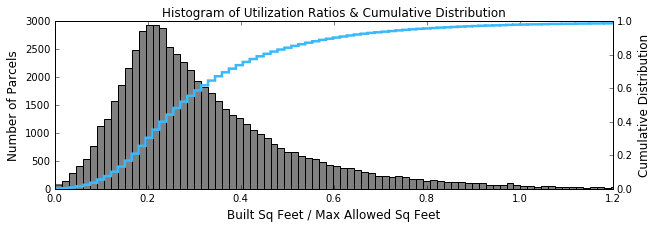

In [27]:
fig, ax1 = pl.subplots()
fig.set_figheight(3)
fig.set_figwidth(10)

nbins = 100

ax1.hist(simp.utilized[simp.utilized < 1.5].values, nbins, color='grey')
ax1.set_title('Histogram of Utilization Ratios & Cumulative Distribution')
ax1.set_xlabel('Built Sq Feet / Max Allowed Sq Feet', fontsize = 12)
ax1.set_ylabel('Number of Parcels', fontsize = 12)
ax1.set_xlim(0,1.2)
# plt.show()

ax2 = ax1.twinx()

ax2.hist(simp.utilized[simp.utilized < 1.5].values, nbins, color='#3BB9FF', normed=1, cumulative=True, 
         histtype='step', lw=2.5)
ax2.set_ylabel('Cumulative Distribution', fontsize = 12)
ax2.set_ylim(0,1)
ax2.set_xlim(0,1.2)
# plt.show()

####Linear Regression -- OLS

In [28]:
set1 = pd.concat([simp.valsqft, simp.utilized], axis=1)
set1.rename(columns={'valsqft':'x', 'utilized':'y'}, inplace=True)
set1 = set1.sort('x')

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [29]:
ols1_value = sm.ols(formula='y ~ x + I((x))', data=set1, missing='drop').fit()

print 'Land Value 1st DEGREE--\n\nParameters:\n', ols1_value.params, '\n'
print 'R-squared:\n', ols1_value.rsquared, '\n'

# print (ols1_value.summary())

ols2_value = sm.ols(formula='y ~ x + I((x)) + I ((x)**2)', data=set1, missing='drop').fit()

print 'Land Value 2nd DEGREE--\n\nParameters:\n', ols2_value.params, '\n'
print 'R-squared:\n', ols2_value.rsquared, '\n'

# print (ols2_value.summary())

ols3_value = sm.ols(formula='y ~ x + I((x)) + I ((x)**2) + I ((x)**3)', data=set1, missing='drop').fit()

print 'Land Value 3rd DEGREE--\n\nParameters:\n', ols2_value.params, '\n'
print 'R-squared:\n', ols2_value.rsquared, '\n'

# print (ols3_value.summary())

Land Value 1st DEGREE--

Parameters:
Intercept    2.624735e-01
x           -1.290631e+10
I((x))       1.290631e+10
dtype: float64 

R-squared:
0.208046960035 

Land Value 2nd DEGREE--

Parameters:
Intercept      0.221822
x              0.015853
I((x))         0.015853
I((x) ** 2)   -0.000111
dtype: float64 

R-squared:
0.229507466323 

Land Value 3rd DEGREE--

Parameters:
Intercept      0.221822
x              0.015853
I((x))         0.015853
I((x) ** 2)   -0.000111
dtype: float64 

R-squared:
0.229507466323 



####Plotting data with best fit lines

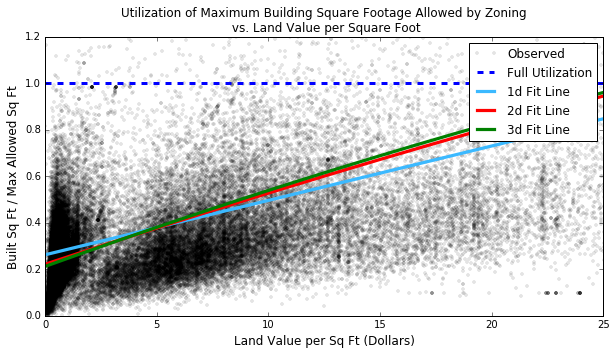

In [30]:
pl.figure(figsize=(10,5))

pl.plot(simp.valsqft, simp.utilized, 
        '.', alpha=.1, label='Observed', color='black')

pl.plot((0, 100), (1, 1), 'b--', lw=3, label='Full Utilization')
pl.plot(set1.x, ols1_value.predict(), label='1d Fit Line', lw=3.2, color='#3BB9FF')
pl.plot(set1.x, ols2_value.predict(), label='2d Fit Line', lw=3.2, color='r')
pl.plot(set1.x, ols3_value.predict(), label='3d Fit Line', lw=3.2, color='g')

pl.xlim(0,25)
pl.xlabel('Land Value per Sq Ft (Dollars)', fontsize = 12)
pl.ylim(0,1.2)
pl.ylabel('Built Sq Ft / Max Allowed Sq Ft', fontsize = 12)
pl.title('Utilization of Maximum Building Square Footage Allowed by Zoning\n vs. Land Value per Square Foot')
pl.legend(fontsize = 12)

In [32]:
median(simp.utilized)

0.28282677910506415

#####Log-likelihood ratio to test linear regression models

In [33]:
lr =  -2*(ols1_value.llf-ols2_value.llf )
print ("1 --> 2 lr = ", lr)

lr =  -2*(ols2_value.llf-ols3_value.llf )
print ("2 --> 3 lr = ", lr)

('1 --> 2 lr = ', 1712.173192219052)
('2 --> 3 lr = ', 88.468079296158976)


#####All ratios are greater than the critical value of 3.84 (for alpha of 0.05)

---
##4. Examining Data by Year Built

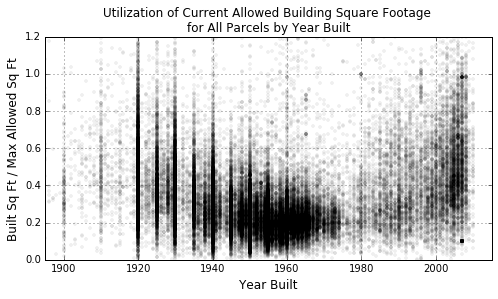

In [34]:
pl.figure(figsize=(8,4))

pl.plot(simp.YrBuilt[simp.YrBuilt>0], simp.utilized[simp.YrBuilt>0], '.', color='black', alpha=0.06)
pl.ylim(0,1.2)
pl.xlim(1895,2015)
pl.title('Utilization of Current Allowed Building Square Footage \nfor All Parcels by Year Built')
pl.ylabel('Built Sq Ft / Max Allowed Sq Ft', fontsize=12)
pl.xlabel('Year Built', fontsize=12)
pl.grid()
# pl.legend()

(1890, 2014)

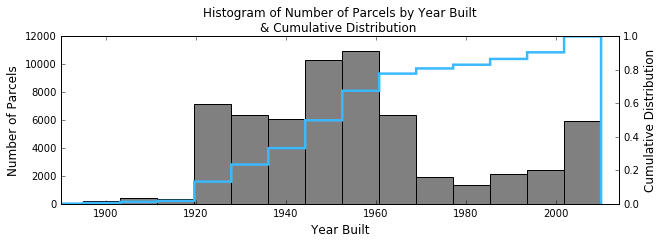

In [35]:
fig, ax1 = pl.subplots()
fig.set_figheight(3)
fig.set_figwidth(10)

nbins = 23

ax1.hist(simp.YrBuilt[simp.YrBuilt > 0].values, nbins, color='grey')
ax1.set_title('Histogram of Number of Parcels by Year Built\n& Cumulative Distribution ')
ax1.set_xlabel('Year Built', fontsize = 12)
ax1.set_ylabel('Number of Parcels', fontsize = 12)
ax1.set_xlim(1890,2014)
# plt.show()

ax2 = ax1.twinx()

ax2.hist(simp.YrBuilt[simp.YrBuilt > 0].values, nbins, color='#3BB9FF', normed=1, cumulative=True, 
         histtype='step', lw=2.5)
ax2.set_ylabel('Cumulative Distribution', fontsize = 12)
ax2.set_ylim(0,1)
ax2.set_xlim(1890,2014)
# plt.show()

In [36]:
median(simp.YrBuilt[simp.YrBuilt > 0])

1953.0

##5. Examining Land Value per Sq Ft

(0, 3)

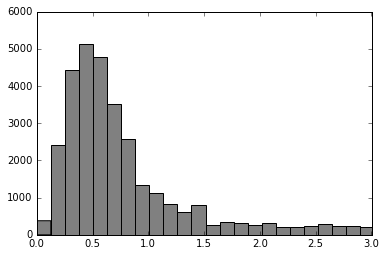

In [37]:
nbins = 2000
pl.hist(simp.valsqft.values, nbins, color='grey')
pl.xlim(0,3)

In [31]:
hist(simp.valsqft[simp.valsqft<=3].values, nbins, color='grey')

NameError: name 'simp' is not defined